In [1]:
import numpy as np 
import pandas as pd 
import os
import shutil
import glob
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
def create_data_path(base_path,input_path):
    try:
        os.makedirs(os.path.join(base_path,'training'))
        os.makedirs(os.path.join(base_path, 'training/0'))
        os.makedirs(os.path.join(base_path, 'training/1'))
        os.makedirs(os.path.join(base_path,'validation'))
        os.makedirs(os.path.join(base_path, 'validation/1'))
        os.makedirs(os.path.join(base_path, 'validation/0'))
    except:
        print("the folders already exist")
    list_dir=glob.glob(os.path.join(input_path,'*'))
    print(list_dir)
    for id in list_dir:
        list_file_0=glob.glob(os.path.join(id,'0/*'))
        list_file_1= glob.glob(os.path.join(id, '1/*'))
        for file_0 in list_file_0:
            src_path = file_0
            dst_path = os.path.join(os.path.join(base_path, 'training/0'), os.path.basename(file_0))
            shutil.copy(src_path, dst_path)

        for file_1 in list_file_1:
            src_path = file_1
            dst_path = os.path.join(os.path.join(base_path, 'training/1'), os.path.basename(file_1))
            shutil.copy(src_path, dst_path)

2024-07-01 05:07:42.858108: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 05:07:42.858218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 05:07:42.984098: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def remove_dir(base_path):
    try:
        shutil.rmtree(os.path.join(base_path,'training'))
        shutil.rmtree(os.path.join(base_path,'validation'))
    except Exception as e:
        print("problem removing directories")
        print(str(e))

In [3]:
#for cleanup
remove_dir('/kaggle/working/')

problem removing directories
[Errno 2] No such file or directory: '/kaggle/working/training'


In [4]:
create_data_path('/kaggle/working/','/kaggle/input/breast-histopathology-images/')

['/kaggle/input/breast-histopathology-images/10295', '/kaggle/input/breast-histopathology-images/10304', '/kaggle/input/breast-histopathology-images/12868', '/kaggle/input/breast-histopathology-images/10274', '/kaggle/input/breast-histopathology-images/12818', '/kaggle/input/breast-histopathology-images/14190', '/kaggle/input/breast-histopathology-images/12869', '/kaggle/input/breast-histopathology-images/9323', '/kaggle/input/breast-histopathology-images/10291', '/kaggle/input/breast-histopathology-images/12906', '/kaggle/input/breast-histopathology-images/9176', '/kaggle/input/breast-histopathology-images/8984', '/kaggle/input/breast-histopathology-images/10299', '/kaggle/input/breast-histopathology-images/12930', '/kaggle/input/breast-histopathology-images/9344', '/kaggle/input/breast-histopathology-images/12935', '/kaggle/input/breast-histopathology-images/12894', '/kaggle/input/breast-histopathology-images/12909', '/kaggle/input/breast-histopathology-images/9381', '/kaggle/input/b

In [5]:
def split_training_validation(base_path,split_size):
    list_file_0=glob.glob(os.path.join(base_path,'training/0/*'))
    list_file_1 = glob.glob(os.path.join(base_path, 'training/1/*'))
    tot_file=list_file_1+list_file_0
    random.shuffle(tot_file)
    training_set=tot_file[0:int(len(tot_file)*split_size)]
    validation_set=tot_file[int(len(tot_file)*split_size):]
    for file in validation_set:
        if file[-5]=='0':
            dst_path = os.path.join(os.path.join(base_path, 'validation/0'), os.path.basename(file))
            shutil.copy(file, dst_path)
        elif file[-5]=='1':
            dst_path = os.path.join(os.path.join(base_path, 'validation/1'), os.path.basename(file))
            shutil.copy(file, dst_path)

In [6]:
training_split=0.8
split_training_validation('/kaggle/working/',training_split)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def create_data_generator(base_path,target_size):
    # All images will be rescaled by 1./255
    train_datagen = ImageDataGenerator(rescale=1 / 255)
    validation_datagen = ImageDataGenerator(rescale=1 / 255)

    # Flow training images in batches of 64 using train_datagen generator
    train_generator = train_datagen.flow_from_directory(
        os.path.join(base_path,'training/'),  # This is the source directory for training images
        target_size=target_size,  
        batch_size=16,
        # Since you use binary_crossentropy loss, you need binary labels
        class_mode='binary')

    # Flow validation images in batches of 64 using validation_datagen generator
    validation_generator = validation_datagen.flow_from_directory(
        os.path.join(base_path,'validation/'),  # This is the source directory for validation images
        target_size=target_size,  
        batch_size=16,
        # Since you use binary_crossentropy loss, you need binary labels
        class_mode='binary')
    return train_generator,validation_generator

In [8]:
train_generator,validation_generator=create_data_generator('/kaggle/working/',(50,50))

Found 277524 images belonging to 2 classes.
Found 55505 images belonging to 2 classes.


In [9]:
import tensorflow as tf

def create_model(input_shape):
    model = tf.keras.models.Sequential([
        # First convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        # Second convolutional block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        # Third convolutional block
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        # Fourth convolutional block
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        
        # First fully connected layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        
        # Second fully connected layer
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        
        # Only 1 output neuron. 
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])


    # Custom callback definition (assuming it exists in your context)
    class CustomCallback(tf.keras.callbacks.Callback):
        # Define your custom callback methods here
        pass

    my_cb = CustomCallback()

    # Updated ReduceLROnPlateau callback
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=5, 
        verbose=1, 
        min_lr=1e-6
    )




    # EarlyStopping callback to stop training when validation loss doesn't improve
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True, 
        verbose=1
    )

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )

    return model, [reduce_lr, early_stopping, my_cb]

In [10]:
import tensorflow as tf
class CustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        if (logs.get('val_accuracy') > 0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [11]:
model,callbacks=create_model((50,50,3))
model.summary()
#Fit model
history = model.fit(
      train_generator,
      epochs=50,
      verbose=1,
      validation_data = validation_generator,callbacks=callbacks)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,945,217 (7.42 MB)

 Trainable params: 1,945,217 (7.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   21/17346 ━━━━━━━━━━━━━━━━━━━━ 2:21 8ms/step - accuracy: 0.7005 - loss: 0.6360

I0000 00:00:1719812658.202264      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719812658.222822      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17346/17346 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8200 - loss: 0.4131

W0000 00:00:1719812811.536041      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17346/17346 ━━━━━━━━━━━━━━━━━━━━ 190s 10ms/step - accuracy: 0.8200 - loss: 0.4131 - val_accuracy: 0.8603 - val_loss: 0.3296 - learning_rate: 1.0000e-04
Epoch 2/50
17346/17346 ━━━━━━━━━━━━━━━━━━━━ 167s 10ms/step - accuracy: 0.8587 - loss: 0.3336 - val_accuracy: 0.8736 - val_loss: 0.2974 - learning_rate: 1.0000e-04
Epoch 3/50
17346/17346 ━━━━━━━━━━━━━━━━━━━━ 164s 9ms/step - accuracy: 0.8675 - loss: 0.3132 - val_accuracy: 0.8798 - val_loss: 0.2879 - learning_rate: 1.0000e-04
Epoch 4/50
17346/17346 ━━━━━━━━━━━━━━━━━━━━ 164s 9ms/step - accuracy: 0.8747 - loss: 0.2987 - val_accuracy: 0.8709 - val_loss: 0.3100 - learning_rate: 1.0000e-04
Epoch 5/50
17346/17346 ━━━━━━━━━━━━━━━━━━━━ 168s 10ms/step - accuracy: 0.8794 - loss: 0.2881 - val_accuracy: 0.8907 - val_loss: 0.2672 - learning_rate: 1.0000e-04
Epoch 6/50
17346/17346 ━━━━━━━━━━━━━━━━━━━━ 165s 10ms/step - accuracy: 0.8851 - loss: 0.2763 - val_accuracy: 0.8954 - val_loss: 0.2546 - learning_rate: 1.0000e-04
Epoch 7/50
17346/17346 ━━━━━━━━━━━━

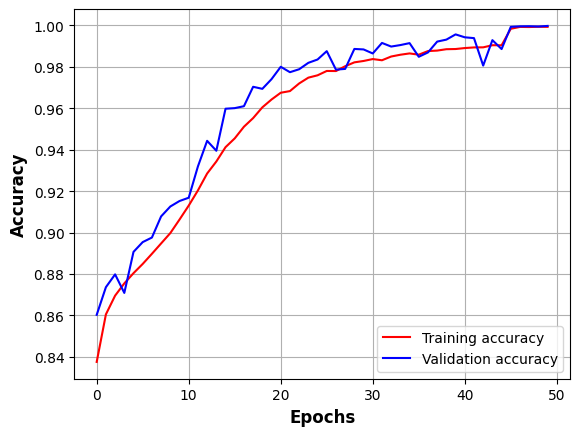

In [12]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy', markersize=5)
plt.plot(epochs, val_acc, 'b', label='Validation accuracy', markersize=5)
plt.grid(True)
plt.xlabel('Epochs', fontsize=12, fontweight='bold')  # Bold and increase font size for x-axis label
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')  # Bold and increase font size for y-axis label
plt.legend(loc='lower right')
plt.show()

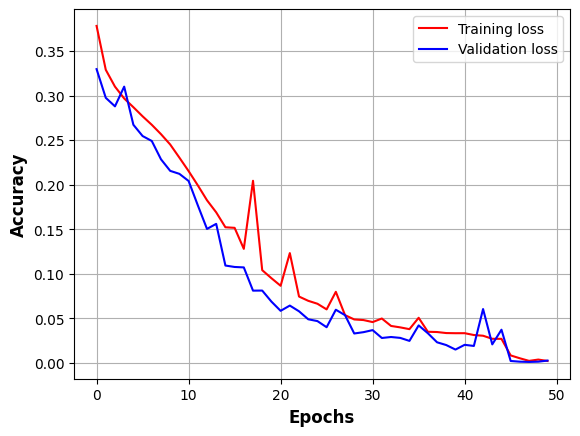

In [13]:
plt.plot(epochs, loss, 'r', label='Training loss', markersize=5)  # Increase markersize
plt.plot(epochs, val_loss, 'b', label='Validation loss', markersize=5)  # Increase markersize
plt.xlabel('Epochs', fontsize=12, fontweight='bold')  # Bold and increase font size for x-axis label
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')  # Bold and increase font size for y-axis label
plt.grid(True)  # Turn on grid
plt.legend(loc=0)
plt.show()